# NFL 49ers - Check Retention Scores
* StellarAlgo Data Science
* Grant Donst
* Aug 23, 2022

In [250]:
import pandas as pd

import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from pycaret.classification import *

### Let's grab the training and eval datasets:

In [251]:
df_train = pd.read_csv("./data/train.csv")
df_eval = pd.read_csv("./data/eval.csv")

In [252]:
df_train = pd.concat([df_train, df_eval])

In [253]:
df_train = df_train[df_train["year"] <= 2018]

In [254]:
df_train.head(100)

,attendancePercent,clientcode,dimCustomerMasterId,distToVenue,isNextYear_Buyer,lkupclientid,missed_games_1,missed_games_2,missed_games_over_2,productGrouping,recency,recentDate,renewedBeforeDays,source_tenure,totalSpent,year
0,0.000000,NFL49ERS,47462,0,0,95,0,0,1,Full Season,0,1970-01-01,203,5475,3000.0,2018
1,0.000000,NFL49ERS,194216,0,1,95,0,0,1,Full Season,0,1970-01-01,203,3650,13000.0,2018
2,0.777778,NFL49ERS,49589,0,1,95,1,1,0,Full Season,0,2018-12-23,203,5840,3000.0,2018
3,0.222222,NFL49ERS,305558,0,1,95,0,0,2,Full Season,5,2018-12-23,203,3650,1700.0,2018
4,0.400000,NFL49ERS,61243734,0,0,95,3,0,0,Full Season,1,2018-10-07,61,3285,650.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.888889,NFL49ERS,280832,0,1,95,1,0,0,Full Season,0,2018-12-16,203,2555,2500.0,2018
188,0.777778,NFL49ERS,361036,0,1,95,1,1,0,Full Season,0,2018-12-23,203,17520,1900.0,2018
189,0.277778,NFL49ERS,60953,0,1,95,1,0,1,Full Season,1,2018-12-23,203,3285,3000.0,2018
190,0.208333,NFL49ERS,61282574,0,1,95,0,0,1,Full Season,2,2018-11-12,203,3650,10000.0,2018


In [255]:
df_train["year"].value_counts()

2018    18179
Name: year, dtype: int64

### Let's set up our new model:

In [256]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9441,0.6952,0.9977,0.9460,0.9711,0.1028,0.1829,0.0580


### Let's finalize our new model so it can be used to make predictions:

In [257]:
final_model = create_model(best_model)
new_retention_model = finalize_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6975,0.9979,0.9448,0.9706,0.0756,0.1488
1,0.9431,0.6732,0.9993,0.9436,0.9707,0.0399,0.1153
2,0.9443,0.6965,0.9973,0.9466,0.9713,0.1121,0.1891
3,0.9476,0.7286,0.9986,0.9485,0.9729,0.1713,0.2781
4,0.9463,0.7437,0.9986,0.9473,0.9723,0.1352,0.2381
5,0.9437,0.7344,0.9986,0.9448,0.9710,0.0588,0.1335
6,0.9456,0.6832,0.9986,0.9466,0.9719,0.1166,0.2157
7,0.9417,0.6195,0.9966,0.9447,0.9699,0.0718,0.1271
8,0.9450,0.6827,0.9979,0.9466,0.9716,0.1313,0.2225


### Let's also load the model used in retention for production:

In [258]:
prod_retention_model = load_model("./models/model")

Transformation Pipeline and Model Successfully Loaded


### Let's use the new and existing model to make predictions on the 2022 season:

In [259]:
inference_data = pd.read_csv("./data/inference_data.csv")
inference_data.columns = ['attendancePercent', 'clientcode', 'dimCustomerMasterId', 'distToVenue', 'isNextYear_Buyer', 'lkupclientid',
                          'missed_games_1', 'missed_games_2', 'missed_games_over_2', 'productGrouping', 'recency', 'recentDate',
                          'renewedBeforeDays', 'source_tenure', 'totalSpent', 'year']

inference_data = inference_data.loc[inference_data['lkupclientid']==95]

In [260]:
inference_data["year"].value_counts()

2021    18274
Name: year, dtype: int64

### Let's use our model to make predictions on the inference data:

In [261]:
df_new_predictions = predict_model(new_retention_model, data=inference_data, raw_score=True)
df_prod_predictions = predict_model(prod_retention_model, data=inference_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9542,0.6301,0.9959,0.9578,0.9765,0.1267,0.1840


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.2241,0.5108,0.1916,0.9769,0.3203,0.0107,0.0517


In [262]:
df_new_predictions.head()

,attendancePercent,clientcode,dimCustomerMasterId,distToVenue,isNextYear_Buyer,lkupclientid,missed_games_1,missed_games_2,missed_games_over_2,productGrouping,recency,recentDate,renewedBeforeDays,source_tenure,totalSpent,year,Label,Score_0,Score_1
0,0.000000,NFL49ERS,1304,0,1,95,0,0,1,Full Season,0,1970-01-01,104,2920,13600.0,2021,1,0.0462,0.9538
1,0.722222,NFL49ERS,1361,0,1,95,1,1,0,Full Season,0,2022-01-02,104,3650,4500.0,2021,1,0.0618,0.9382
2,0.000000,NFL49ERS,1392,0,1,95,0,0,1,Full Season,0,1970-01-01,104,2555,26600.0,2021,1,0.1154,0.8846
3,0.555556,NFL49ERS,1403,0,1,95,1,2,0,Full Season,0,2022-01-02,104,6205,7800.0,2021,1,0.0102,0.9898
4,0.000000,NFL49ERS,1412,0,0,95,0,0,1,Full Season,0,1970-01-01,147,2920,2416.0,2021,1,0.1683,0.8317


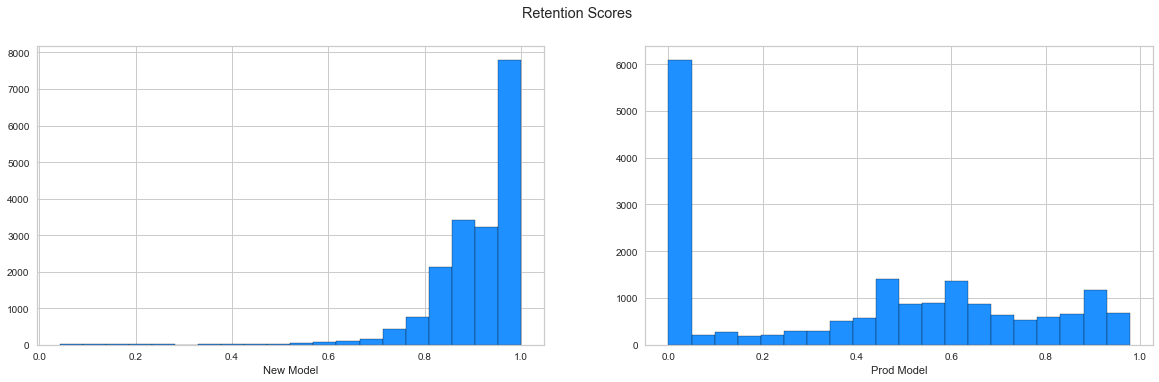

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Scores')
ax1.hist(df_new_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_prod_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('New Model')
ax2.set_xlabel('Prod Model')

fig.figure.set_figwidth(20)

In [264]:
df_new_predictions["Score_1"].value_counts()

0.8513    297
0.8723    253
0.8641    238
0.8721    173
0.9615    125
         ... 
0.9992      1
0.2662      1
0.7535      1
0.5878      1
0.7206      1
Name: Score_1, Length: 2643, dtype: int64

### There are a large number of fans in the 0 - 0.1 score bucket, let's run a pandas profile on the dataset to check data quality:

In [265]:
df_low_scores = df_new_predictions[df_new_predictions["Score_1"] <= 0.1]

In [266]:
df_train["recency"].value_counts(bins=10)

(-0.009000000000000001, 0.8]    9605
(0.8, 1.6]                      2480
(1.6, 2.4]                      1941
(2.4, 3.2]                      1203
(5.6, 6.4]                      1035
(3.2, 4.0]                       986
(4.8, 5.6]                       653
(7.2, 8.0]                       161
(6.4, 7.2]                       115
(4.0, 4.8]                         0
Name: recency, dtype: int64

In [267]:
df_low_scores["Score_1"].value_counts(bins=20)

(0.0652, 0.0678]    2
(0.0854, 0.088]     2
(0.0526, 0.0551]    2
(0.0703, 0.0728]    2
(0.0414, 0.045]     1
(0.088, 0.0905]     1
(0.0804, 0.0829]    1
(0.0778, 0.0804]    1
(0.0728, 0.0753]    1
(0.0905, 0.093]     1
(0.0627, 0.0652]    1
(0.0551, 0.0577]    1
(0.0501, 0.0526]    1
(0.045, 0.0476]     0
(0.0602, 0.0627]    0
(0.0753, 0.0778]    0
(0.0577, 0.0602]    0
(0.0829, 0.0854]    0
(0.0476, 0.0501]    0
(0.0678, 0.0703]    0
Name: Score_1, dtype: int64

In [268]:
# generate a pandas profile report on the dataset
profile = ProfileReport(df_train, minimal=True)
profile.to_file("pandas-profile-report-2018.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]